# **Spark HW2 Moive Recommendation**
In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

# Set Up Environments

## Spark

- https://medium.com/grabngoinfo/install-pyspark-3-on-google-colab-the-easy-way-577ec4a2bcd8

In [ ]:
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Download Spark
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
# Unzip the file
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
# Set up the enviornment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.2.1-bin-hadoop3.2'
# Install library for finding Spark
!pip install -q findspark
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark
# Import a Spark function from library
from pyspark.sql.functions import col

## Libraries 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Datasets

In [ ]:
# cd /content/drive/MyDrive/Laioffer/csv_files/RecSys_Movie/

/content/drive/MyDrive/Laioffer/csv_files/RecSys_Movie


In [ ]:
ls

links.csv    README.txt                     spark-3.2.1-bin-hadoop3.2.tgz.1
movies.csv   spark-3.2.1-bin-hadoop3.2/     tags.csv
ratings.csv  spark-3.2.1-bin-hadoop3.2.tgz


In [ ]:
movies_df = spark.read.load("drive/MyDrive/Laioffer/csv_files/RecSys_Movie/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("drive/MyDrive/Laioffer/csv_files/RecSys_Movie/ratings.csv", format='csv', header = True)
links_df = spark.read.load("drive/MyDrive/Laioffer/csv_files/RecSys_Movie/links.csv", format='csv', header = True)
tags_df = spark.read.load("drive/MyDrive/Laioffer/csv_files/RecSys_Movie/tags.csv", format='csv', header = True)

In [ ]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [ ]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [ ]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [ ]:
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [ ]:
tmp1 = sum(ratings_df.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user


# Part 1: Spark SQL and OLAP

In [ ]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


### Q1: The number of Users

In [ ]:
# Method - 1
q1_result=spark.sql("Select Count(Distinct userId) as Number_of_Users from ratings")
q1_result.show()

+---------------+
|Number_of_Users|
+---------------+
|            610|
+---------------+



In [ ]:
# Method - 2
# all users should be computed by both ratings and tags
# in case some users leave raings but no tag while some users leave tags but no rating
nuser=spark.sql('SELECT COUNT(DISTINCT userId) ' +\
                'FROM (' +\
	                'SELECT DISTINCT userId ' +\
	                'FROM ratings ' +\
	                'UNION ' +\
	                'SELECT DISTINCT userId ' +\
	                'FROM tags' +\
                ')').toPandas()
print('Total number of users is ',nuser.iloc[0,0])

Total number of users is  610


### Q2: The number of Movies

In [ ]:
q2_result=spark.sql("Select Count(movieId) as Number_of_Moives from movies")
q2_result.show()

+----------------+
|Number_of_Moives|
+----------------+
|            9742|
+----------------+



### Q3:  How many movies are rated by users? List movies not rated before

In [ ]:
# number of movies rated
q3_result_1=spark.sql("Select Count(movieId) as Number_of_Rated_Moives From movies Where movieID in (Select movieId From ratings)")
q3_result_1.show()

+----------------------+
|Number_of_Rated_Moives|
+----------------------+
|                  9724|
+----------------------+



In [ ]:
# movies that have not been rated before: 50 movies as an example
unrated_list=spark.sql('SELECT * ' +\
                       'FROM movies ' +\
                       'WHERE movieId NOT IN ( ' +\
                        'SELECT movieId ' +\
                        'FROM ratings ' +\
                       ') ' +\
                       'LIMIT 50')
print('50 movies that have not been rated by users:')
unrated_list.show()

50 movies that have not been rated by users:
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|   1076|Innocents, The (1...|Drama|Horror|Thri...|
|   2939|      Niagara (1953)|      Drama|Thriller|
|   3338|For All Mankind (...|         Documentary|
|   3456|Color of Paradise...|               Drama|
|   4194|I Know Where I'm ...|   Drama|Romance|War|
|   5721|  Chosen, The (1981)|               Drama|
|   6668|Road Home, The (W...|       Drama|Romance|
|   6849|      Scrooge (1970)|Drama|Fantasy|Mus...|
|   7020|        Proof (1991)|Comedy|Drama|Romance|
|   7792|Parallax View, Th...|            Thriller|
|   8765|This Gun for Hire...|Crime|Film-Noir|T...|
|  25855|Roaring Twenties,...|Crime|Drama|Thriller|
|  26085|Mutiny on the Bou...|Adventure|Drama|R...|
|  30892|In the Realms of ...|Animation|Documen...|
|  32160|Twentieth Century...|              Comedy|
|  32371|Call North

### Q4: List Movie Genres

In [ ]:
genres_list=spark.sql('select genres from movies').toPandas()
spark.sql('select distinct genres from movies').show()

+--------------------+
|              genres|
+--------------------+
|Comedy|Horror|Thr...|
|Adventure|Sci-Fi|...|
|Action|Adventure|...|
| Action|Drama|Horror|
|Action|Animation|...|
|Animation|Childre...|
|Action|Adventure|...|
|    Adventure|Sci-Fi|
|Documentary|Music...|
|Adventure|Childre...|
| Adventure|Animation|
| Musical|Romance|War|
|Action|Adventure|...|
|Adventure|Childre...|
|Comedy|Crime|Horr...|
|Crime|Drama|Fanta...|
|Comedy|Mystery|Th...|
|   Adventure|Fantasy|
|Horror|Romance|Sc...|
|Drama|Film-Noir|R...|
+--------------------+
only showing top 20 rows



In [ ]:
q4_result=spark.sql("Select Distinct explode(split(genres,'[|]')) as genres From movies Order by 1")
q4_result.show()

+------------------+
|            genres|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



### Q5: Movie for Each Category

In [ ]:
# size of each category 
q5_result_1=spark.sql("Select genres,Count(movieId) as Number_of_Moives From(Select explode(split(genres,'[|]')) as genres, movieId From movies) Group By 1 Order by 2 DESC")
q5_result_1.show()

+------------------+----------------+
|            genres|Number_of_Moives|
+------------------+----------------+
|             Drama|            4361|
|            Comedy|            3756|
|          Thriller|            1894|
|            Action|            1828|
|           Romance|            1596|
|         Adventure|            1263|
|             Crime|            1199|
|            Sci-Fi|             980|
|            Horror|             978|
|           Fantasy|             779|
|          Children|             664|
|         Animation|             611|
|           Mystery|             573|
|       Documentary|             440|
|               War|             382|
|           Musical|             334|
|           Western|             167|
|              IMAX|             158|
|         Film-Noir|              87|
|(no genres listed)|              34|
+------------------+----------------+



In [ ]:
# list all movie for each category 
q5_result_2=spark.sql("Select genres, concat_ws(',',collect_set(title)) as list_of_movies From(Select explode(split(genres,'[|]')) as genres, title From movies) Group By 1")
q5_result_2.show()

+------------------+--------------------+
|            genres|      list_of_movies|
+------------------+--------------------+
|             Crime|Stealing Rembrand...|
|           Romance|Vampire in Brookl...|
|          Thriller|Element of Crime,...|
|         Adventure|Ice Age: Collisio...|
|             Drama|Airport '77 (1977...|
|               War|General, The (192...|
|       Documentary|The Barkley Marat...|
|           Fantasy|Masters of the Un...|
|           Mystery|Before and After ...|
|           Musical|U2: Rattle and Hu...|
|         Animation|Ice Age: Collisio...|
|         Film-Noir|Rififi (Du rififi...|
|(no genres listed)|T2 3-D: Battle Ac...|
|              IMAX|Harry Potter and ...|
|            Horror|Underworld: Rise ...|
|           Western|Man Who Shot Libe...|
|            Comedy|Hysteria (2011),H...|
|          Children|Ice Age: Collisio...|
|            Action|Stealing Rembrand...|
|            Sci-Fi|Push (2009),SORI:...|
+------------------+--------------

# Part2: Spark ALS based approach for training model
We will use an Spark ML to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

## Bkgd Info

- In collaborative filtering, matrix factorization is the state-of-the-art solution for sparse data problem

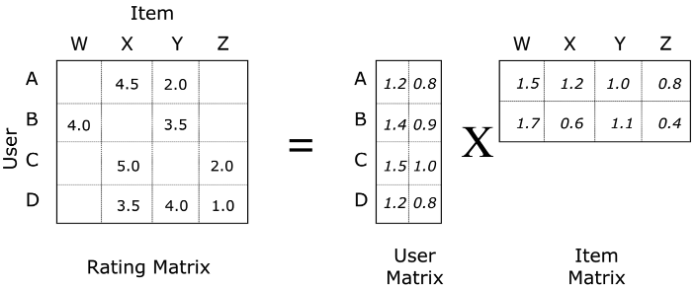

*  Hybrid Recommender System

- a matrix factorization is a factorization of a matrix into a product of matrices. In the case of collaborative filtering, matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. One matrix can be seen as the user matrix where rows represent users and columns are latent factors. The other matrix is the item matrix where rows are latent factors and columns represent items.

Q: How does matrix factorization solve the problems listed in Part One?


1. Model learns to factorize rating matrix into user and movie representations, which allows model to predict better personalized movie ratings for users


2. With matrix factorization, less-known movies can have rich latent representations as much as popular movies have, which improves recommender’s ability to recommend less-known movies


Q: Why using Alternating Least Square (ALS) algorithm?


A: Alternating Least Square (ALS) is also a matrix factorization algorithm and it runs itself in a parallel fashion. ALS is implemented in Apache Spark ML and built for a larges-scale collaborative filtering problems. ALS is doing a pretty good job at solving scalability and sparseness of the Ratings data, and it’s simple and scales well to very large datasets.



## Datasets

In [ ]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [ ]:
movie_ratings=ratings_df.drop('timestamp')

In [ ]:
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [ ]:
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



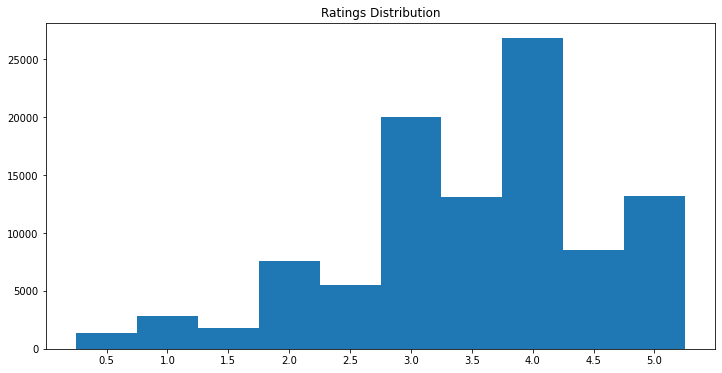

In [ ]:
# bar chart of ratings
rating_count=movie_ratings.select('rating').groupBy('rating').count().toPandas()
plt.figure(figsize=[12,6])
plt.bar(x='rating',height='count',data=rating_count,width=0.5)
plt.title('Ratings Distribution')
plt.xticks(np.arange(0.5,5.5,0.5))
plt.show()

## ALS Model Selection and Evaluation


ALS has its own set of hyper-parameters. We need to tune its hyper-parameters via hold-out validation or cross-validation.

* https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html



Most important hyper-params in Alternating Least Square (ALS):

1. maxIter: the maximum number of iterations to run (defaults to 10);
2. rank: the number of latent factors in the model (defaults to 10);
3. regParam: the regularization parameter in ALS (defaults to 1.0);

* With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [ ]:
# Import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [ ]:
#Create test and train set
(training,test) = movie_ratings.randomSplit([0.8,0.2])

In [ ]:
#Create ALS model
model_als = ALS(maxIter=5, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", seed=6) 

In [ ]:
#Tune model using ParamGridBuilder
params = ParamGridBuilder()\
            .addGrid(model_als.maxIter, [3, 5, 10])\
            .addGrid(model_als.regParam, [0.1, 0.01, 0.001])\
            .addGrid(model_als.rank, [5, 10, 15, 20, 25])\
            .addGrid(model_als.alpha, [0.1, 0.01, 0.001])\
            .build()

# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")


# Build Cross validation 
cv = CrossValidator(estimator=model_als, estimatorParamMaps=params, evaluator=evaluator, numFolds=5, seed=6)


#Fit ALS model to training data
cvModel = cv.fit(training)


#Extract best model from the tuning exercise using ParamGridBuilder
bestModel=cvModel.bestModel

In [ ]:
# Check the best parameters
best_params = cvModel.getEstimatorParamMaps()[np.argmin(cvModel.avgMetrics)]
print('Best ALS model parameters by CV:')
for i,j in best_params.items():
  print('-> '+i.name+': '+str(j))

Best ALS model parameters by CV:
-> maxIter: 10
-> regParam: 0.1
-> rank: 5
-> alpha: 0.001


In [ ]:
#Extract best model from the tuning exercise using ParamGridBuilder
prediction_train=cvModel.transform(training)
rmse_train = evaluator.evaluate(prediction_train)
print("Root-mean-square error for training data is " + str(rmse_train))

Root-mean-square error for training data is 0.6398945531244535


## Model testing
And finally, make a prediction and check the testing error.

In [ ]:
#Generate predictions and evaluate using RMSE
predictions=bestModel.transform(test)
rmse = evaluator.evaluate(predictions)

In [ ]:
#Print evaluation metrics and model parameters
print ("RMSE = "+str(rmse))
print ("**Best Model**")
print (" Rank: ", str(bestModel._java_obj.parent().getRank())),
print (" MaxIter: ", str(bestModel._java_obj.parent().getMaxIter())), 
print (" RegParam: ", str(bestModel._java_obj.parent().getRegParam()))

RMSE = 0.8836250878919011
**Best Model**
 Rank:  5
 MaxIter:  10
 RegParam:  0.1


In [ ]:
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   148|    356|   4.0| 3.7657478|
|   148|  40815|   4.0|    3.8131|
|   148|  69757|   3.5|  3.263859|
|   148|  69844|   4.0|  3.804972|
|   148|  72998|   4.0| 3.6250765|
|   148|  79091|   3.5| 3.4490366|
|   148|  89745|   4.0| 3.6186872|
|   148| 115617|   3.5|  4.153109|
|   463|   1320|   4.0|  3.170158|
|   463|   1690|   4.0|  3.400602|
|   463|   6539|   3.5| 3.9498272|
|   463|   8622|   3.5| 3.4691813|
|   471|   8360|   2.0| 3.2989185|
|   471|   8874|   3.5| 3.7421734|
|   471|  79702|   5.0| 3.4359753|
|   496|    720|   1.0|  4.242107|
|   496|   8640|   2.0| 2.4660428|
|   496|  95167|   3.0| 2.9924216|
|   496| 109374|   4.0| 3.8914952|
|   496| 111362|   3.5| 3.3108256|
+------+-------+------+----------+
only showing top 20 rows



## Model apply and see the performance

In [ ]:
alldata = bestModel.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.6929703080938372


In [ ]:
alldata.registerTempTable("alldata")

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


In [ ]:
spark.sql("Select * From alldata").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   463|   1088|   3.5|  3.457125|
|   137|   1580|   3.5|  3.269813|
|   580|   1580|   4.0| 3.1779938|
|   580|   3175|   2.5| 3.2437632|
|   580|  44022|   3.5| 3.6461797|
|   133|    471|   4.0|  3.235838|
|   322|   1580|   3.5| 2.9584172|
|   362|   1591|   4.0| 3.1369288|
|   362|   1645|   5.0|  3.791946|
|   593|   1580|   1.5| 2.6383846|
|   597|    471|   2.0|  3.745034|
|   597|   1580|   3.0|   3.84422|
|   597|   1959|   4.0| 3.9066827|
|   597|   2366|   5.0|  4.402144|
|   108|   1959|   5.0| 4.3439016|
|   155|   1580|   4.0|  3.715425|
|   155|   3175|   4.0|  3.657722|
|    34|   1580|   2.5|  3.441351|
|    34|   3997|   2.0| 1.9063611|
|   368|   1580|   3.0| 2.8580298|
+------+-------+------+----------+
only showing top 20 rows



In [ ]:
spark.sql('SELECT * ' +\
          'FROM movies ' +\
	          'JOIN alldata ON movies.movieId = alldata.movieId').show()

+-------+--------------------+--------------------+------+-------+------+----------+
|movieId|               title|              genres|userId|movieId|rating|prediction|
+-------+--------------------+--------------------+------+-------+------+----------+
|    356| Forrest Gump (1994)|Comedy|Drama|Roma...|   148|    356|   4.0| 3.7657478|
|   1197|Princess Bride, T...|Action|Adventure|...|   148|   1197|   3.0| 3.8731802|
|   4308| Moulin Rouge (2001)|Drama|Musical|Rom...|   148|   4308|   4.0| 3.7461302|
|   4886|Monsters, Inc. (2...|Adventure|Animati...|   148|   4886|   3.0|  3.480479|
|   4896|Harry Potter and ...|Adventure|Childre...|   148|   4896|   4.0|  3.328757|
|   4993|Lord of the Rings...|   Adventure|Fantasy|   148|   4993|   3.0| 3.5715837|
|   5618|Spirited Away (Se...|Adventure|Animati...|   148|   5618|   3.0| 3.7605228|
|   5816|Harry Potter and ...|   Adventure|Fantasy|   148|   5816|   4.0|  3.467592|
|   5952|Lord of the Rings...|   Adventure|Fantasy|   148|   5952

## 小总结：
1. A new user inputs his/her favorite movies, then system create new user-movie interaction samples for the model (or based on a user's previous records)


2. System retrains ALS model on data with the new inputs
System creates movie data for inference (in this case, we sample all movies from the data)


3. System make rating predictions on all movies for that user


4. System outputs top N movie recommendations for that user based on the ranking of movie rating predictions

## Recommend moive to users with id: 575, 232. 
you can choose some users to recommend the moives 

In [ ]:
# define a function to package the recommendation
def topKRecommend(k,id,model):
  '''
  k: the number of movies to recommend
  id: the id of the user to give recommendations
  model: the trained model for recommendation
  '''
  # the table for all top10 recommendations
  all_recommd=model.recommendForAllUsers(k)
  user_recommd=all_recommd.where(all_recommd.userId==id).toPandas()
  if user_recommd.shape[0]==0:
    print('No user with id '+str(id)+' is found in the data.')
    return None
  user_recommd=user_recommd.iloc[0,1]
  user_recommd=pd.DataFrame(user_recommd,columns=['movieId','predicted_ratings'])
  temp=None
  for i in user_recommd['movieId']:
    if not temp:
      temp=movies_df.where(movies_df.movieId==str(i))
    else:
      temp=temp.union(movies_df.where(movies_df.movieId==str(i)))
  out=pd.concat([temp.toPandas(),user_recommd['predicted_ratings']],axis=1)
  out.index=range(1,k+1)
  return out



# top 10 for user 575
topKRecommend(10,575,bestModel)

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


,movieId,title,genres,predicted_ratings
1,170355,Mulholland Dr. (1999),Drama|Mystery|Romance,5.905772
2,3379,On the Beach (1959),Drama,5.905772
3,59018,"Visitor, The (2007)",Drama|Romance,5.704554
4,60943,Frozen River (2008),Drama,5.704554
5,99764,It's Such a Beautiful Day (2012),Animation|Comedy|Drama|Fantasy|Sci-Fi,5.683535
6,40491,"Match Factory Girl, The (Tulitikkutehtaan tytt...",Comedy|Drama,5.683535
7,96004,Dragon Ball Z: The History of Trunks (Doragon ...,Action|Adventure|Animation,5.629771
8,8477,"Jetée, La (1962)",Romance|Sci-Fi,5.591304
9,148881,World of Tomorrow (2015),Animation|Comedy,5.569840
10,33649,Saving Face (2004),Comedy|Drama|Romance,5.418531


In [ ]:
# top 15 for user 232
topKRecommend(15,232,bestModel)

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


,movieId,title,genres,predicted_ratings
1,3200,"Last Detail, The (1973)",Comedy|Drama,5.234698
2,5075,Waydowntown (2000),Comedy,4.833593
3,26928,"Summer's Tale, A (Conte d'été) (1996)",Comedy|Drama|Romance,4.774889
4,74226,"Dream of Light (a.k.a. Quince Tree Sun, The) (...",Documentary|Drama,4.774889
5,184245,De platte jungle (1978),Documentary,4.774889
6,7071,"Woman Under the Influence, A (1974)",Drama,4.774889
7,179135,Blue Planet II (2017),Documentary,4.774889
8,117531,Watermark (2014),Documentary,4.774889
9,84273,Zeitgeist: Moving Forward (2011),Documentary,4.774889
10,26073,"Human Condition III, The (Ningen no joken III)...",Drama|War,4.774889


## Find the similar moives for moive with id: 463, 471

1.   列表项
2.   列表项


You can find the similar moives based on the ALS results

In [ ]:
# access the movie factor matrix
movie_factors=bestModel.itemFactors
movie_factors.printSchema()
comd=["movie_factors.selectExpr('id as movieId',"]
for i in range(bestModel.rank):
  if i<bestModel.rank-1:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"',")
  else:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"'")
comd.append(')')
movie_factors=eval(''.join(comd))
movie_factors.createOrReplaceTempView('movie_factors')
movie_factors.show()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

+-------+----------+----------+-----------+-----------+-----------+
|movieId|  feature0|  feature1|   feature2|   feature3|   feature4|
+-------+----------+----------+-----------+-----------+-----------+
|     10| 1.4107805| 0.9967687|  0.8568432| 0.12477699|  0.6807661|
|     20|0.72226334| 1.1994116|  0.4653073|  0.7887089|-0.07002083|
|     30| 0.2537034| 0.2916545|  0.1971029|-0.03790866|0.114110254|
|     40|0.29851136|  1.968345|  1.5256921|-0.14002444|-0.11588023|
|     50| 1.2198292| 1.5073633|  1.2187777|  0.7092623|-0.05819176|
|     60| 0.5553128| 1.0688968|  1.2458516|-0.19296128| 0.47187358|
|     70|0.47685808| 1.8821862| 0.83606464|-0.14842685|   0.280538|
|     80| 0.7996558| 1.3633393| 0.93189067|  0.8562009|-0.45008406|
|    100| 0.4584945|  0.906077|   1.401047|-0.10538862|-0.18064007|
|    110|  1.303784| 1.1115855|  1.2558775| 0.52057713|

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
# method 1: Euclidean distance based similarity
# the smaller the euclidean distance between the factors, the similar the movies
# this similarity considers the actual strength,
# e.g. movie 1 with factor [1,2,3] and movie 2 with factor [2,4,6] are considered not similar enough
def dist_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  temp=['select movieId,']
  for i in range(bestModel.rank):
    val=movie_info.iloc[0,i+1]
    if val>0:
      comd='feature'+str(i)+'-'+str(val)
    else:
      comd='feature'+str(i)+'+'+str(-val)
    if i<bestModel.rank-1:
      temp.append('('+comd+')*('+comd+') as sd'+str(i)+',')
    else:
      temp.append('('+comd+')*('+comd+') as sd'+str(i))
  temp.append('from movie_factors where movieId!='+str(mid))  
  ssd=spark.sql(' '.join(temp))
  ssd=ssd.selectExpr('movieId','sd0+sd1+sd2+sd2+sd4 as ssd').orderBy('ssd').limit(k).toPandas()
  out=None
  for i in ssd['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, ssd

In [ ]:
# method 2: cosine similarity
# the larger the cosine value, the smaller the two feature vectors' angle, the similar the movies
# this similarity considers the direction only,
# e.g. movie 1 with factor [1,2,3] and movie 2 with factor [2,4,6] are considered the same
def cos_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  norm_m=sum(movie_info.iloc[0,1:].values**2)**0.5
  temp=['select movieId,']
  norm_str=['sqrt(']
  for i in range(bestModel.rank):
    comd='feature'+str(i)+'*'+str(movie_info.iloc[0,i+1])
    temp.append(comd+' as inner'+str(i)+',')
    if i<bestModel.rank-1:      
      norm_str.append('feature'+str(i)+'*feature'+str(i)+'+')
    else:
      norm_str.append('feature'+str(i)+'*feature'+str(i))
  norm_str.append(') as norm')
  temp.append(''.join(norm_str))
  temp.append(' from movie_factors where movieId!='+str(mid))  
  inner=spark.sql(' '.join(temp))
  inner=inner.selectExpr('movieId',\
                         '(inner0+inner1+inner2+inner3+inner4)/norm/'+str(norm_m)+' as innerP').\
                         orderBy('innerP',ascending=False).limit(k).toPandas()
  out=None
  for i in inner['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, inner

In [ ]:
# movie id 463, method 1, top 10 similar
out11,ssd1=dist_similar(10,463)

No movie with id 463 is found in the data.


In [ ]:
# movie id 463, method 2, top 10 similar
out12,inner1=cos_similar(10,463)

No movie with id 463 is found in the data.


In [ ]:
# movie id 471, method 1, top 10 similar
out21,ssd2=dist_similar(10,471)
out21

,movieId,title,genres
1,277,Miracle on 34th Street (1994),Drama
2,48142,"Black Dahlia, The (2006)",Crime|Drama|Mystery|Thriller
3,2261,One Crazy Summer (1986),Comedy
4,5521,"Principal, The (1987)",Action|Crime|Drama
5,574,Spanking the Monkey (1994),Comedy|Drama
6,2472,Tough Guys (1986),Comedy
7,2111,"Man with Two Brains, The (1983)",Comedy
8,1840,He Got Game (1998),Drama
9,151,Rob Roy (1995),Action|Drama|Romance|War
10,700,Angus (1995),Comedy


In [ ]:
# movie id 471, method 2, top 10 similar
out22,inner2=cos_similar(10,471)
out22

,movieId,title,genres
1,45730,Lady in the Water (2006),Drama|Fantasy|Mystery
2,1837,"Odd Couple II, The (1998)",Comedy
3,27839,"Ring Two, The (2005)",Drama|Horror|Mystery|Thriller
4,3983,You Can Count on Me (2000),Drama|Romance
5,3397,"Great Muppet Caper, The (1981)",Children|Comedy
6,1078,Bananas (1971),Comedy|War
7,3677,Baraka (1992),Documentary
8,27830,"Bobby Jones, Stroke of Genius (2004)",Drama
9,8131,Pursuit of Happiness (2001),Comedy|Romance
10,44197,Find Me Guilty (2006),Comedy|Crime|Drama


In [ ]:
# movie id 10, method 1, top 5 similar
out31,ssd3=dist_similar(5,10)
out31

,movieId,title,genres
1,161580,Bad Moms (2016),Comedy
2,107348,Anchorman 2: The Legend Continues (2013),Comedy
3,3668,Romeo and Juliet (1968),Drama|Romance
4,111617,Blended (2014),Comedy
5,3082,"World Is Not Enough, The (1999)",Action|Adventure|Thriller


In [ ]:
# movie id 10, method 2, top 5 similar
out42,inner3=cos_similar(5,10)
out42

,movieId,title,genres
1,140715,Straight Outta Compton (2015),Drama
2,102445,Star Trek Into Darkness (2013),Action|Adventure|Sci-Fi|IMAX
3,2266,"Butcher's Wife, The (1991)",Comedy|Romance
4,101142,"Croods, The (2013)",Adventure|Animation|Comedy
5,5523,"Adventures of Pluto Nash, The (2002)",Action|Adventure|Comedy|Sci-Fi
